# Machine learning on the case of the volatile molecules

Данный блокнот предназначен для прогнозирования летучести органических соединений с помощью основ машинного обучения.  

Здесь представлена работа с датасетом `exp_logVP_data`, содержащим данные об индивидуальных органических соединениях и их давлении насыщеных паров [Па] при 298.15 K, полученных из статьи [`R. Naef, W. E. Acree Jr., Molecules 2021, 26, 1045`].

Мы исследуем зависимость давлением насыщеных паров от молекулярной структуры и других физико-химических свойств соединений. На основе этих данных построим модель машинного обучения для **предсказания давлением насыщеных паров только по структурной формуле молекулы**.

Такая модель может быть полезна для:

- Скрининга больших баз химических соединений на предмет поиска перспективных летучих соединений
- Понимания влияния структуры молекулы на её летучесть
- Для оценки летучести "опасных" соединений, когда экспериментальное измерение невозможно

## План:

- Подготовка данных
- Исследование некоторых классических моделей
- Поиск оптимальной модели и обучение
- Использование модели

In [3]:
pip install rdkit

   ---------------------------------------- 0.0/21.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/21.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/21.0 MB 325.1 kB/s eta 0:01:05
   ---------------------------------------- 0.1/21.0 MB 655.4 kB/s eta 0:00:32
   ---------------------------------------- 0.2/21.0 MB 952.6 kB/s eta 0:00:22
    --------------------------------------- 0.3/21.0 MB 1.2 MB/s eta 0:00:18
    --------------------------------------- 0.4/21.0 MB 1.3 MB/s eta 0:00:16
   - -------------------------------------- 0.7/21.0 MB 2.1 MB/s eta 0:00:10
   - -------------------------------------- 1.0/21.0 MB 2.8 MB/s eta 0:00:08
   - -------------------------------------- 1.0/21.0 MB 2.8 MB/s eta 0:00:08
   - -------------------------------------- 1.0/21.0 MB 2.8 MB/s eta 0:00:08
   - -------------------------------------- 1.0/21.0 MB 2.8 MB/s eta 0:00:08
   - -------------------------------------- 1.0/21.0 MB 2.8 MB/s eta 0:00:08
   - --

In [1]:
# general tools
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# RDkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski

# Data processing

Загрузим наш датасет и посмотрим, как он выглядит:

In [2]:
df = pd.read_csv('exp_logVP_data.csv', sep=";", header = 0, index_col=False, encoding='latin-1')
df['SMILES'] = df['SMILES'].astype(str)

In [3]:
df.head()

,name,SMILES,logVP exp
0,(-)-Methyl jasmonate,O=C1[C@@H]([C@H](CC1)CC(=O)OC)C\C=C/CC,-0.91
1,(-)-trans-Pinocarveol,CC1([C@@H]2C[C@H](C([C@H]1C2)=C)O)C,1.34
2,(+)-trans-Myrtanol,CC1([C@@H]2CC[C@H]([C@H]1C2)CO)C,0.37
3,(2-Bromoethyl)benzene,BrCCC1=CC=CC=C1,1.51
4,(Chloromethyl)benzene,ClCC1=CC=CC=C1,2.24


**Вторая** колонка в нашем датасете это - **Smiles** - интерпретация молекулы в понятном для компьютера виде.
<br>
Большую часть соединений из статьи удалось конвертировать автоматически в **Smiles** через сайт https://opsin.ch.cam.ac.uk/, написав небольшой скрипт. Однако 230 пришлось конвертировать вручную, около 30 из которых оказались с не совсем корректными названиями. Например, аббревеатуры по типу DDD или Hexane-1,5-dinitrate / Hexyl-1,2-dinitrate. Я тут предположил, что Hexyl это все таки Hexane. Но вобще было бы правильно назвать их 1,5-Hexanediol dinitrate / 1,2-Hexanediol dinitrate.
<br>
Отметим, что **Smiles** легко можно получить нарисовав соответствующую молекулу, например, здесь: https://cactus.nci.nih.gov/cgi-bin/osra/index.cgi

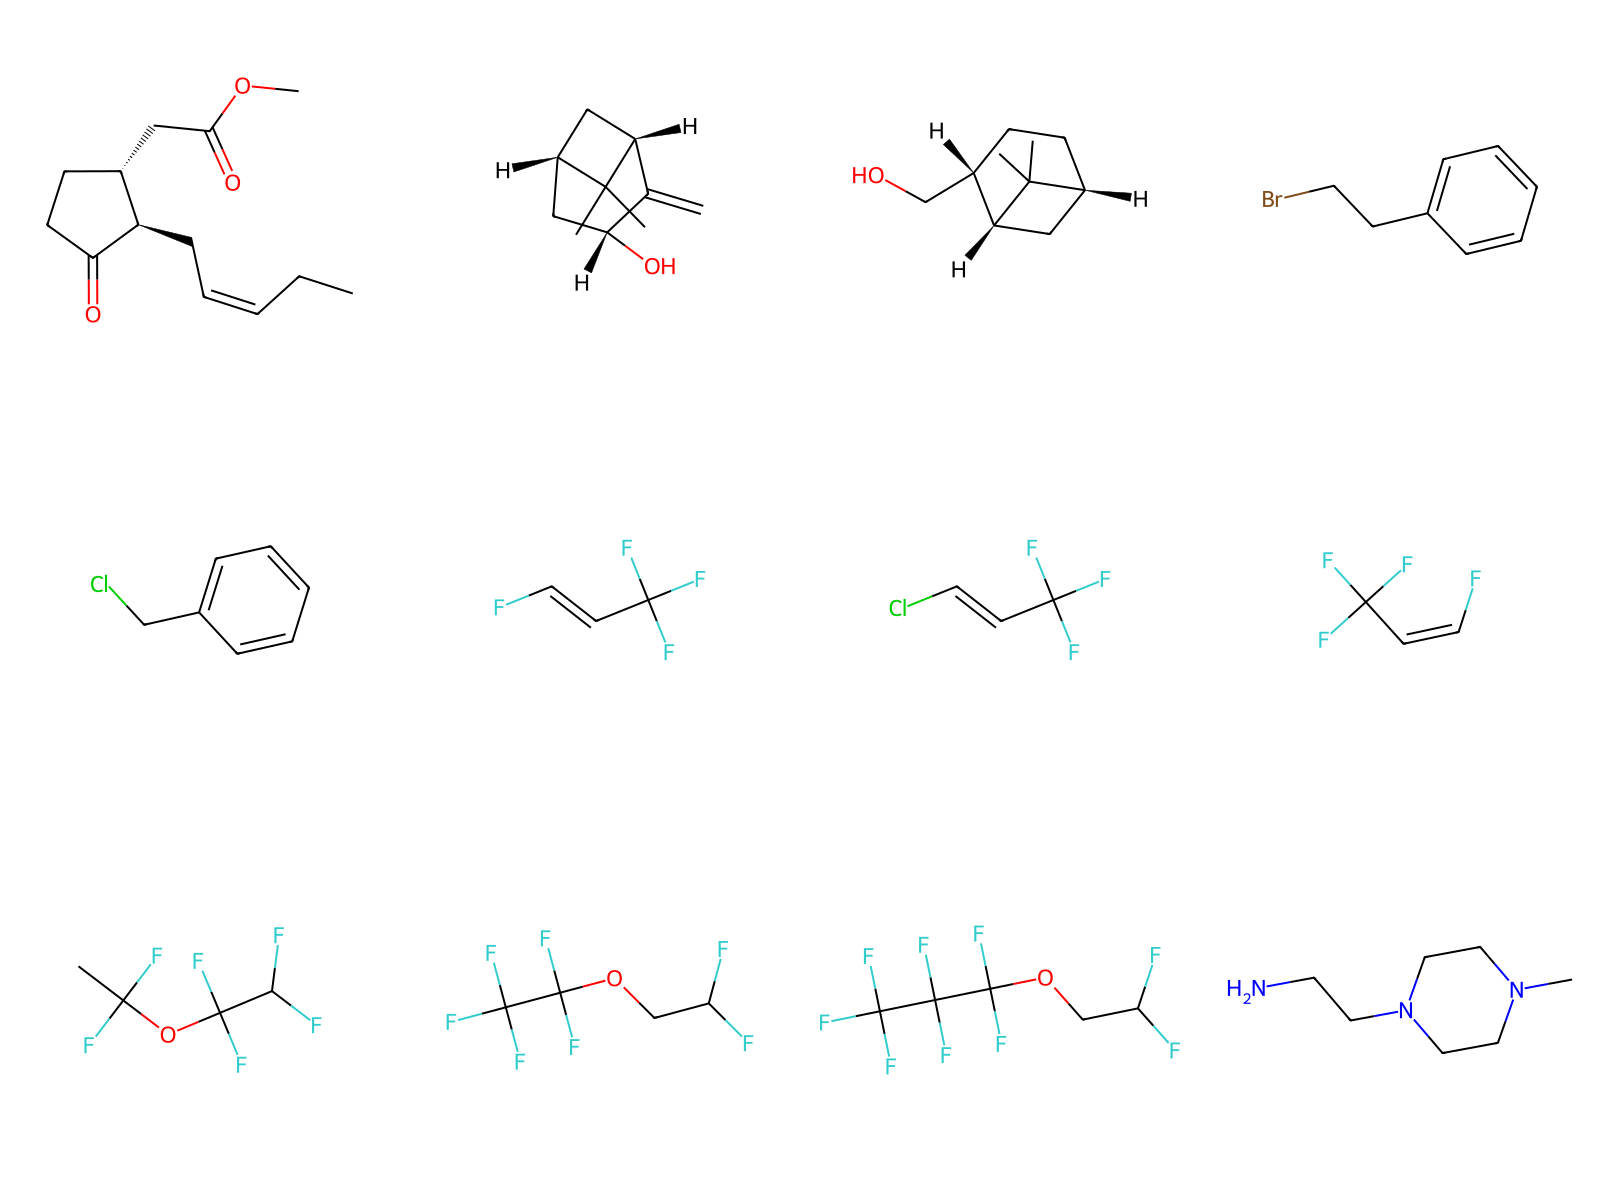

In [47]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in df[0:12].SMILES],molsPerRow=4, subImgSize=(400,400))

Видим, что присутствуют разнообразные молекулы - есть как циклические, так и линейные структуры. Присутсвуют гетероатомы.

In [3]:
if len(df) == len(df.drop_duplicates()):
    print('Очевидных дупликатов нет')
else:
    print('%.2f процентов данных являются дубликатами' % len(dataset.drop_duplicates())/len(dataset) * 100)

Очевидных дупликатов нет


In [79]:
# Пропусков нет
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1906 entries, 0 to 1905
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1906 non-null   object 
 1   SMILES     1906 non-null   object 
 2   logVP exp  1906 non-null   float64
dtypes: float64(1), object(2)
memory usage: 44.8+ KB


## Дескрипторы для предсказания летучести

Для точного предсказания летучести мы будем выгружать дополнительные дескрипторы из библиотеки `RDKit`. Отметим, что выбор дескрипторов основан на *химической логике, интуиции*. 

Представленные ниже дескрипторы могут хорошо коррелировать с летучестью, потому что они отражают важные структурные особенности органических молекул, которые влияют энергию кристаллической решетки.

<br>

- **Молекулярная масса (`ExactMolWt`)**, чем выше, тем ниже летучесть при прочих равных

- **Размер, форма, компактность молекулы (`BCUT2D_MRHI, Kappa2`)** - чем больше разветвлена молекула, тем выше взаимное отталкивание, тем выше летучесть

- **Топологическая сложность (`BalabanJ`)** - отражает стабильность соединения, чем она выше, тем стабильнее и ниже летучесть

- **Разветвлённость (`HallKierAlpha`)** - разветвленность может как повышать, так и понижать летучесть

- **Электронные свойства поверхности (`PEOE_VSA6`)** - влияют на взаимодействие молекул между собой, т.е. взаимное отталкивание или притяжение

- **Число тяжелых атомов (`HeavyAtomCount`)** - галогены, например, влияют на летучесть, обычно взаимным отталкиванием (но может быть и притяжение)

- **Число колец (`RingCount`)** - чем больше колец, тем больше между ними взаимодействий, тем ниже летучесть

- **Число гетероатомов (`NumHeteroatoms`)** - гетероатомы могут как повышать, так и понижать летучесть

- **Количесво вращаемых фрагментов (`NumRotatableBonds`)** - чем выше число, тем больше взаимного отталкивания, тем выше летучесть

<br>

Функции, необходимые для выгрузки данных дескрипторов, представлены в списке `descriptors`.

In [4]:
desсriptors = [
    Descriptors.ExactMolWt,
    Descriptors.BCUT2D_MRHI,
    Descriptors.BalabanJ,
    Descriptors.HallKierAlpha,
    Descriptors.PEOE_VSA6,
    Lipinski.HeavyAtomCount,
    Lipinski.RingCount,
    Lipinski.NumHeteroatoms,
    Lipinski.NumRotatableBonds
]

Добавим эти дескрипторы в наш датасет:

In [5]:
descriptors_rdkit = []

for smile in tqdm(df['SMILES']):
  mol = Chem.MolFromSmiles(smile)
  if mol is not None:
    descriptor_values = [d(mol) for d in desсriptors]
    descriptors_rdkit.append(descriptor_values)
  else:
    descriptors_rdkit.append([None] * len(desсriptors))


descriptor_names = ['ExactMolWt','BCUT2D_MRHI', 'BalabanJ', 'HallKierAlpha',  'PEOE_VSA6',
                    'HeavyAtomCount','RingCount', 'NumHeteroatoms', 'NumRotatableBonds']

df_rdkit = pd.DataFrame(descriptors_rdkit, columns=descriptor_names)
df = pd.concat([df, df_rdkit], axis=1)

100%|█████████████████████████████████████████████████████████████████████████████| 1906/1906 [00:02<00:00, 761.00it/s]


Датасет выглядит теперь вот так:

In [6]:
df.head()

,name,SMILES,logVP exp,ExactMolWt,BCUT2D_MRHI,BalabanJ,HallKierAlpha,PEOE_VSA6,HeavyAtomCount,RingCount,NumHeteroatoms,NumRotatableBonds
0,(-)-Methyl jasmonate,O=C1[C@@H]([C@H](CC1)CC(=O)OC)C\C=C/CC,-0.91,224.141244,5.841987,2.517961,-1.12,19.075777,16,1,3,5
1,(-)-trans-Pinocarveol,CC1([C@@H]2C[C@H](C([C@H]1C2)=C)O)C,1.34,152.120115,5.224680,2.233205,-0.30,20.426410,11,3,1,0
2,(+)-trans-Myrtanol,CC1([C@@H]2CC[C@H]([C@H]1C2)CO)C,0.37,154.135765,5.023954,2.099511,-0.04,13.847474,11,3,1,1
3,(2-Bromoethyl)benzene,BrCCC1=CC=CC=C1,1.51,183.988762,9.088881,2.614900,-0.30,46.261779,9,1,1,2
4,(Chloromethyl)benzene,ClCC1=CC=CC=C1,2.24,126.023628,6.165421,2.832086,-0.49,30.331835,8,1,1,1


Посмотрим на некоторые графики. Рассмотрим молекулярную массу и логарим давления насыщенных паров

<Axes: >

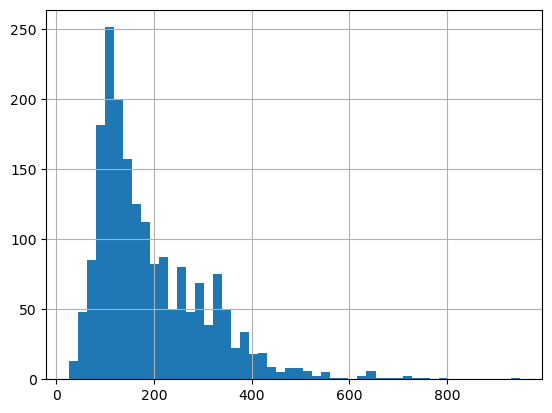

In [83]:
df['ExactMolWt'].hist(bins = 50)

<Axes: >

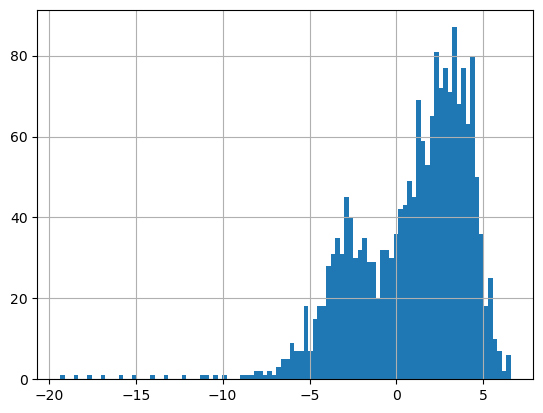

In [84]:
df['logVP exp'].hist(bins = 100)

In [85]:
df[df['ExactMolWt'] > 750]

,name,SMILES,logVP exp,ExactMolWt,BCUT2D_MRHI,BalabanJ,HallKierAlpha,PEOE_VSA6,HeavyAtomCount,RingCount,NumHeteroatoms,NumRotatableBonds
1235,Decabromodiphenyl ether,O(C1=C(C(=C(C(=C1Br)Br)Br)Br)Br)C1=C(C(=C(C(=C...,-8.53,949.178286,9.161621,2.712767,3.04,0.000000,23,2,11,2
1429,Hexapentacontane,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,-19.36,786.892054,4.547803,3.050448,0.00,360.571842,56,0,0,53
1819,Tetrapentacontane,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,-18.53,758.860754,4.545584,3.047098,0.00,347.730199,54,0,0,51


Теперь нам необходимо проанализировать полученные дескрипторы:

 - нет ли среди них коррелирующих между собой?
 - насколько хорошо они коррелируют с нашей таргетной величиной?

In [6]:
# Отделим датафрейм только с числовыми признаками
df_num = df.drop(['SMILES', 'name'], axis = 1)

# Построим матрицу корреляций
corr_matrix = df_num.corr()
corr_matrix

,logVP exp,ExactMolWt,BCUT2D_MRHI,BalabanJ,HallKierAlpha,PEOE_VSA6,HeavyAtomCount,RingCount,NumHeteroatoms,NumRotatableBonds
logVP exp,1.000000,-0.771178,-0.240538,0.206409,0.077961,-0.729029,-0.802833,-0.573958,-0.170191,-0.443946
ExactMolWt,-0.771178,1.000000,0.366917,0.190196,0.110230,0.581820,0.904190,0.439496,0.611920,0.370108
BCUT2D_MRHI,-0.240538,0.366917,1.000000,-0.050066,0.242111,0.037586,0.123351,0.270791,0.186715,-0.139791
BalabanJ,0.206409,0.190196,-0.050066,1.000000,-0.103610,-0.173920,0.221204,-0.357001,0.598522,0.101570
HallKierAlpha,0.077961,0.110230,0.242111,-0.103610,1.000000,0.124089,-0.154026,-0.270642,-0.006460,0.044652
PEOE_VSA6,-0.729029,0.581820,0.037586,-0.173920,0.124089,1.000000,0.694972,0.269821,-0.113641,0.650064
HeavyAtomCount,-0.802833,0.904190,0.123351,0.221204,-0.154026,0.694972,1.000000,0.399556,0.493123,0.575249
RingCount,-0.573958,0.439496,0.270791,-0.357001,-0.270642,0.269821,0.399556,1.000000,0.107219,-0.318859
NumHeteroatoms,-0.170191,0.611920,0.186715,0.598522,-0.006460,-0.113641,0.493123,0.107219,1.000000,-0.048512
NumRotatableBonds,-0.443946,0.370108,-0.139791,0.101570,0.044652,0.650064,0.575249,-0.318859,-0.048512,1.000000


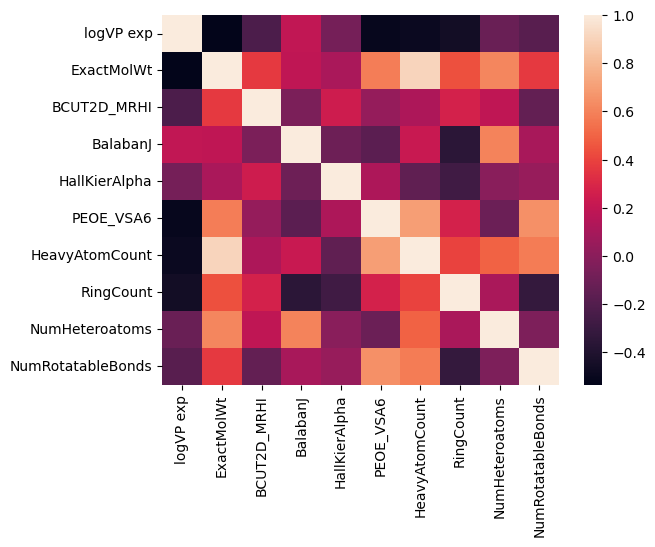

In [41]:
sns.heatmap(corr_matrix)
plt.show()

По матрице видно, что дескрипторы, отвечающие за молекулярную массу, число тяжелых атомов, число колец, а также электронные свойства поверхности сильнее коррелируют с нашей таргетной величиной.

Возможно коррелируют между собой Balabanj и RingCount

# Building a ML model

In [7]:
# Импортируем необходимые библиотеки
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [88]:
df.head()

,name,SMILES,logVP exp,ExactMolWt,BCUT2D_MRHI,BalabanJ,HallKierAlpha,PEOE_VSA6,HeavyAtomCount,RingCount,NumHeteroatoms,NumRotatableBonds
0,(-)-Methyl jasmonate,O=C1[C@@H]([C@H](CC1)CC(=O)OC)C\C=C/CC,-0.91,224.141244,5.841987,2.517961,-1.12,19.075777,16,1,3,5
1,(-)-trans-Pinocarveol,CC1([C@@H]2C[C@H](C([C@H]1C2)=C)O)C,1.34,152.120115,5.224680,2.233205,-0.30,20.426410,11,3,1,0
2,(+)-trans-Myrtanol,CC1([C@@H]2CC[C@H]([C@H]1C2)CO)C,0.37,154.135765,5.023954,2.099511,-0.04,13.847474,11,3,1,1
3,(2-Bromoethyl)benzene,BrCCC1=CC=CC=C1,1.51,183.988762,9.088881,2.614900,-0.30,46.261779,9,1,1,2
4,(Chloromethyl)benzene,ClCC1=CC=CC=C1,2.24,126.023628,6.165421,2.832086,-0.49,30.331835,8,1,1,1


In [8]:
# Разделяем данные на признаки X и целевую переменную y
X = df[['ExactMolWt', 'BCUT2D_MRHI', 'BalabanJ','HallKierAlpha', 'PEOE_VSA6', 'HeavyAtomCount', 'RingCount', 'NumHeteroatoms', 'NumRotatableBonds']]
y = df['logVP exp']

In [9]:
X.head()

,ExactMolWt,BCUT2D_MRHI,BalabanJ,HallKierAlpha,PEOE_VSA6,HeavyAtomCount,RingCount,NumHeteroatoms,NumRotatableBonds
0,224.141244,5.841987,2.517961,-1.12,19.075777,16,1,3,5
1,152.120115,5.224680,2.233205,-0.30,20.426410,11,3,1,0
2,154.135765,5.023954,2.099511,-0.04,13.847474,11,3,1,1
3,183.988762,9.088881,2.614900,-0.30,46.261779,9,1,1,2
4,126.023628,6.165421,2.832086,-0.49,30.331835,8,1,1,1


In [10]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Нормализация данных

<Axes: >

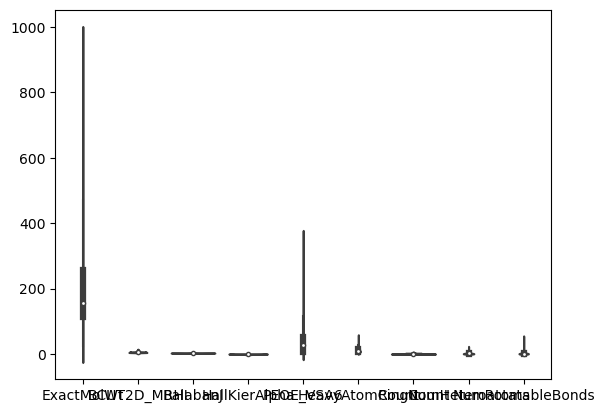

In [92]:
# Визуализируем распределения входных признаков для тренировочной выборки
sns.violinplot(X_train)

Видим, что переменные лежат в заметно разных диапазонах, из-за чего более крупномасштабные признаки могут давать большее влияние на предсказываемую переменную. Для нивелирования этой разницы используется **нормализация признаков**.

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns = X_test.columns)

<Axes: >

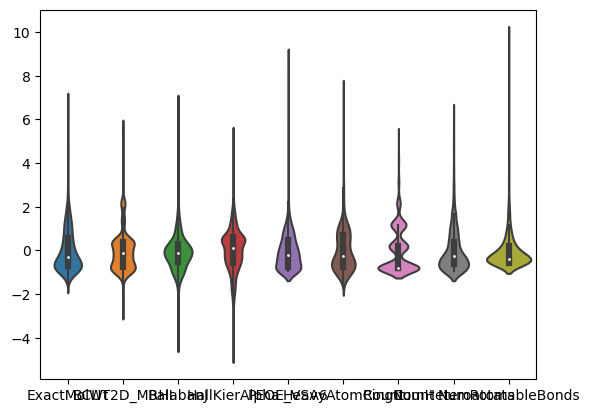

In [94]:
# Визуализируем распределения входных признаков для тренировочной выборки после нормализации
sns.violinplot(X_train)

Видим, что теперь признаки находятся примерно в одном диапазоне значений, благодаря чему не вносят смещения в предсказание `logVP exp`


In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1906 entries, 0 to 1905
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ExactMolWt         1906 non-null   float64
 1   BCUT2D_MRHI        1906 non-null   float64
 2   BalabanJ           1906 non-null   float64
 3   HallKierAlpha      1906 non-null   float64
 4   PEOE_VSA6          1906 non-null   float64
 5   HeavyAtomCount     1906 non-null   int64  
 6   RingCount          1906 non-null   int64  
 7   NumHeteroatoms     1906 non-null   int64  
 8   NumRotatableBonds  1906 non-null   int64  
dtypes: float64(5), int64(4)
memory usage: 134.1 KB


## Модель линейной регрессии


**Линейная регрессия** – регрессионная модель одной переменной y от другой или нескольких переменных x. В процессе используется зависимость линейной функции.

In [13]:
# Строим простую линейную регрессию
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_pred_train = linear_model.predict(X_train)
linear_pred_test = linear_model.predict(X_test)
print('Линейная регрессия:')
print('Обучающая выборка:')
print('RMSE:', mean_squared_error(y_train, linear_pred_train) ** 0.5)
print('R^2:', r2_score(y_train, linear_pred_train))
print('Тестовая выборка:')
print('RMSE:', mean_squared_error(y_test, linear_pred_test) ** 0.5)
print('R^2:', r2_score(y_test, linear_pred_test))

Линейная регрессия:
Обучающая выборка:
RMSE: 1.2825431001054008
R^2: 0.843154649328494
Тестовая выборка:
RMSE: 1.3169695375038748
R^2: 0.8500821180891667


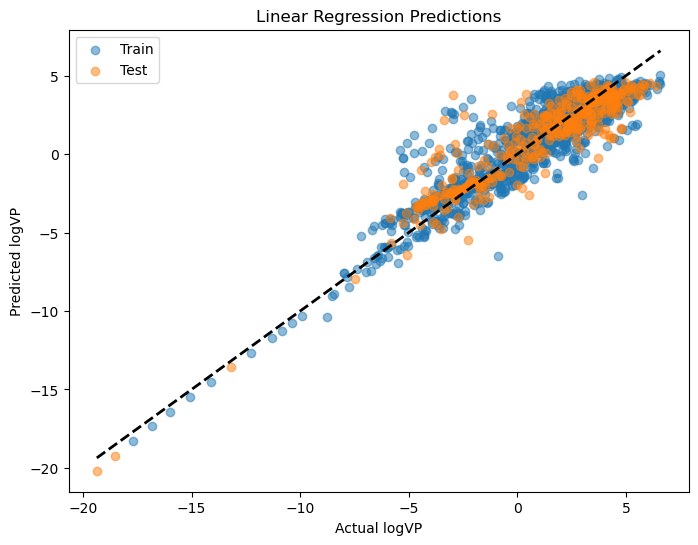

In [14]:
# Построим график предсказанных значений в сопоставлении с реальными
plt.figure(figsize=(8, 6))
plt.scatter(y_train, linear_pred_train, alpha=0.5, label='Train')
plt.scatter(y_test, linear_pred_test, alpha=0.5, label='Test')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual logVP')
plt.ylabel('Predicted logVP')
plt.title('Linear Regression Predictions')
plt.legend()
plt.show()

In [15]:
# Получим коэффициенты для уравнения линейной регрессии для каждого из признаков
importance = linear_model.coef_
for i,v in zip(importance, X_train.columns):
 print(f'{v}, Score: %.5f' % (i))

ExactMolWt, Score: -1.77723
BCUT2D_MRHI, Score: -0.10453
BalabanJ, Score: 0.60670
HallKierAlpha, Score: 0.41986
PEOE_VSA6, Score: -0.52652
HeavyAtomCount, Score: 0.38785
RingCount, Score: -1.12125
NumHeteroatoms, Score: 0.01206
NumRotatableBonds, Score: -1.05999


## Модель дерева решений

**Дерево решений** — это метод представления решающих правил в иерархической структуре, состоящей из элементов двух типов — узлов (node) и листьев (leaf). В узлах находятся решающие правила и производится проверка соответствия примеров этому правилу по какому-либо атрибуту обучающего множества.

In [13]:
# Строим дерево решений
tree_model = DecisionTreeRegressor(max_depth = 3)
tree_model.fit(X_train, y_train)
tree_pred_train = tree_model.predict(X_train)
tree_pred_test = tree_model.predict(X_test)
print('Дерево решений:')
print('Обучающая выборка:')
print('RMSE:', mean_squared_error(y_train, tree_pred_train) ** 0.5)
print('R^2:', r2_score(y_train, tree_pred_train))
print('Тестовая выборка:')
print('RMSE:', mean_squared_error(y_test, tree_pred_test) ** 0.5)
print('R^2:', r2_score(y_test, tree_pred_test))

Дерево решений:
Обучающая выборка:
RMSE: 1.5902199830846748
R^2: 0.7726853764803633
Тестовая выборка:
RMSE: 2.3844927425118967
R^2: 0.3687967976791079


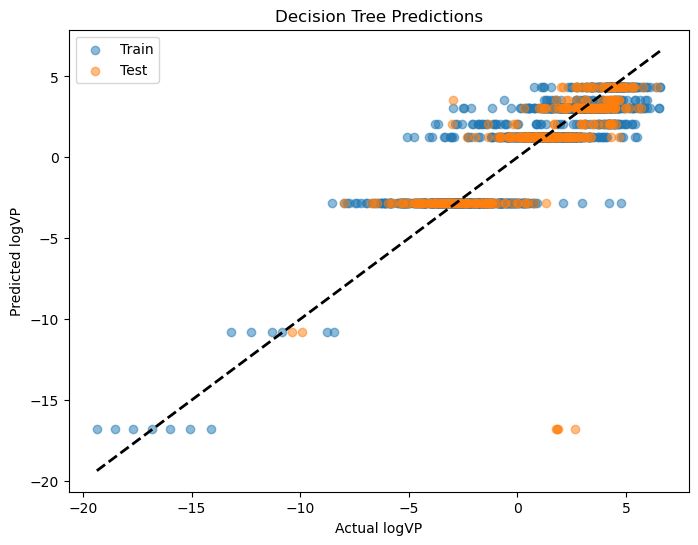

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train, tree_pred_train, alpha=0.5, label='Train')
plt.scatter(y_test, tree_pred_test, alpha=0.5, label='Test')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual logVP')
plt.ylabel('Predicted logVP')
plt.title('Decision Tree Predictions')
plt.legend()
plt.show()

Ступеньки означают переобучение

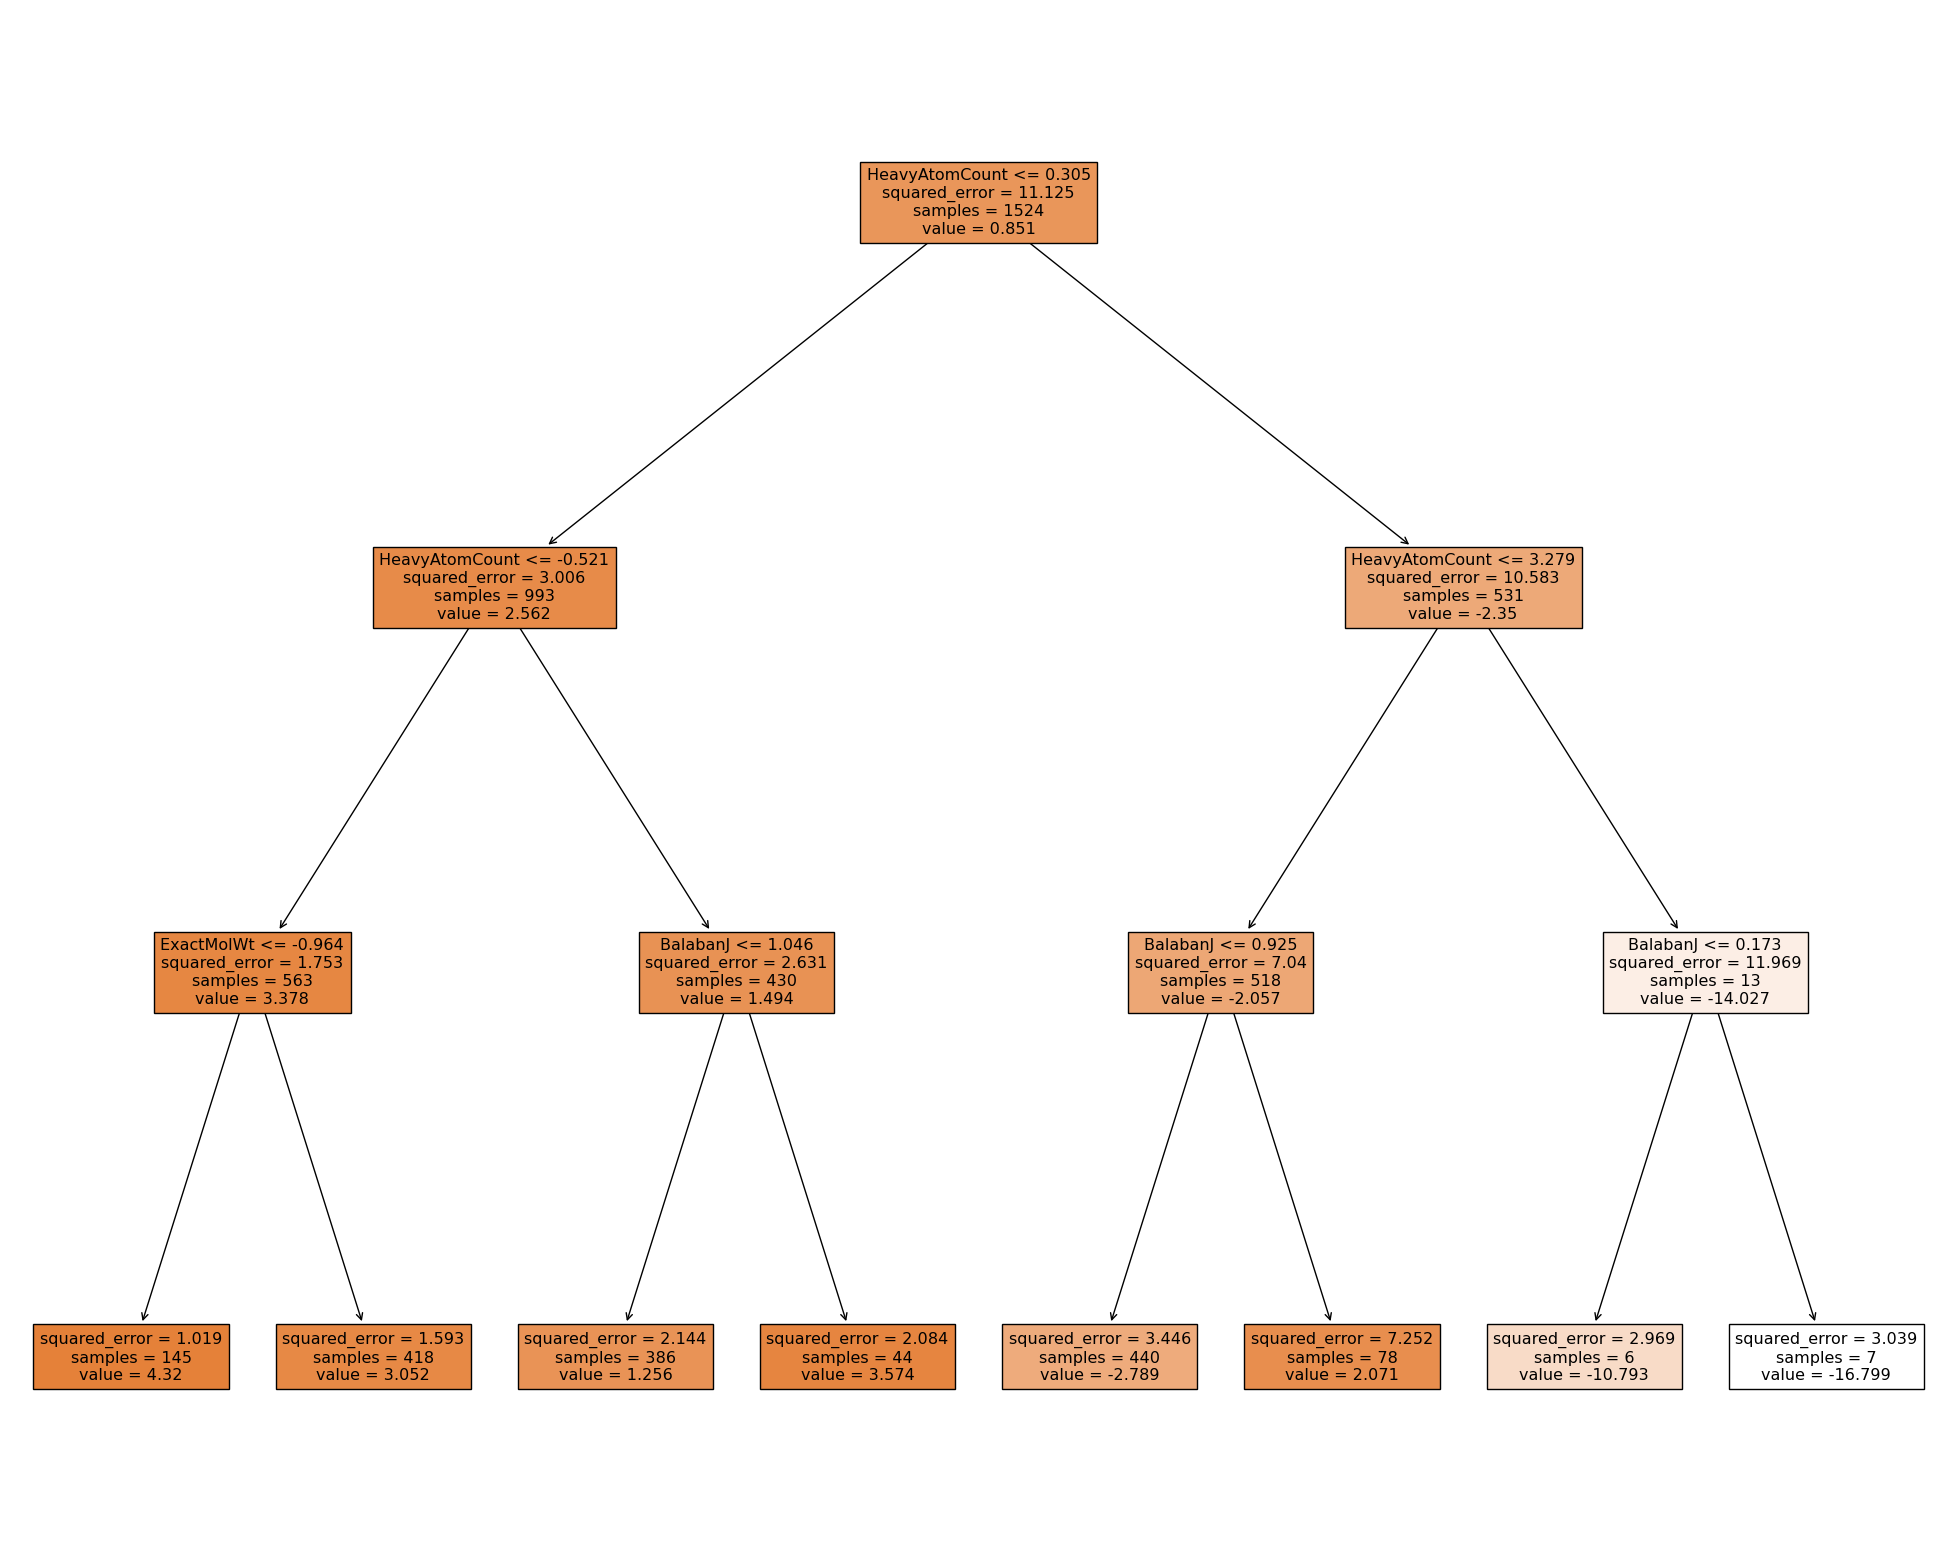

In [101]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_model,
                   feature_names=X_train.columns,
                   filled=True)

In [15]:
# Строим дерево решений с глубиной 10
tree_model = DecisionTreeRegressor(max_depth = 10)
tree_model.fit(X_train, y_train)
tree_pred_train = tree_model.predict(X_train)
tree_pred_test = tree_model.predict(X_test)
print('Дерево решений:')
print('Обучающая выборка:')
print('RMSE:', mean_squared_error(y_train, tree_pred_train) ** 0.5)
print('R^2:', r2_score(y_train, tree_pred_train))
print('Тестовая выборка:')
print('RMSE:', mean_squared_error(y_test, tree_pred_test) ** 0.5)
print('R^2:', r2_score(y_test, tree_pred_test))

Дерево решений:
Обучающая выборка:
RMSE: 0.5229933652116304
R^2: 0.9754130124670495
Тестовая выборка:
RMSE: 2.1978181052643944
R^2: 0.4637581840887236


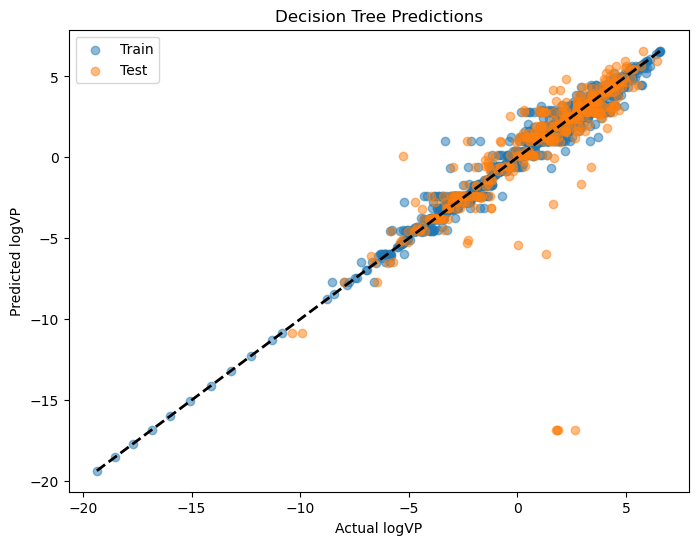

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train, tree_pred_train, alpha=0.5, label='Train')
plt.scatter(y_test, tree_pred_test, alpha=0.5, label='Test')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual logVP')
plt.ylabel('Predicted logVP')
plt.title('Decision Tree Predictions')
plt.legend()
plt.show()

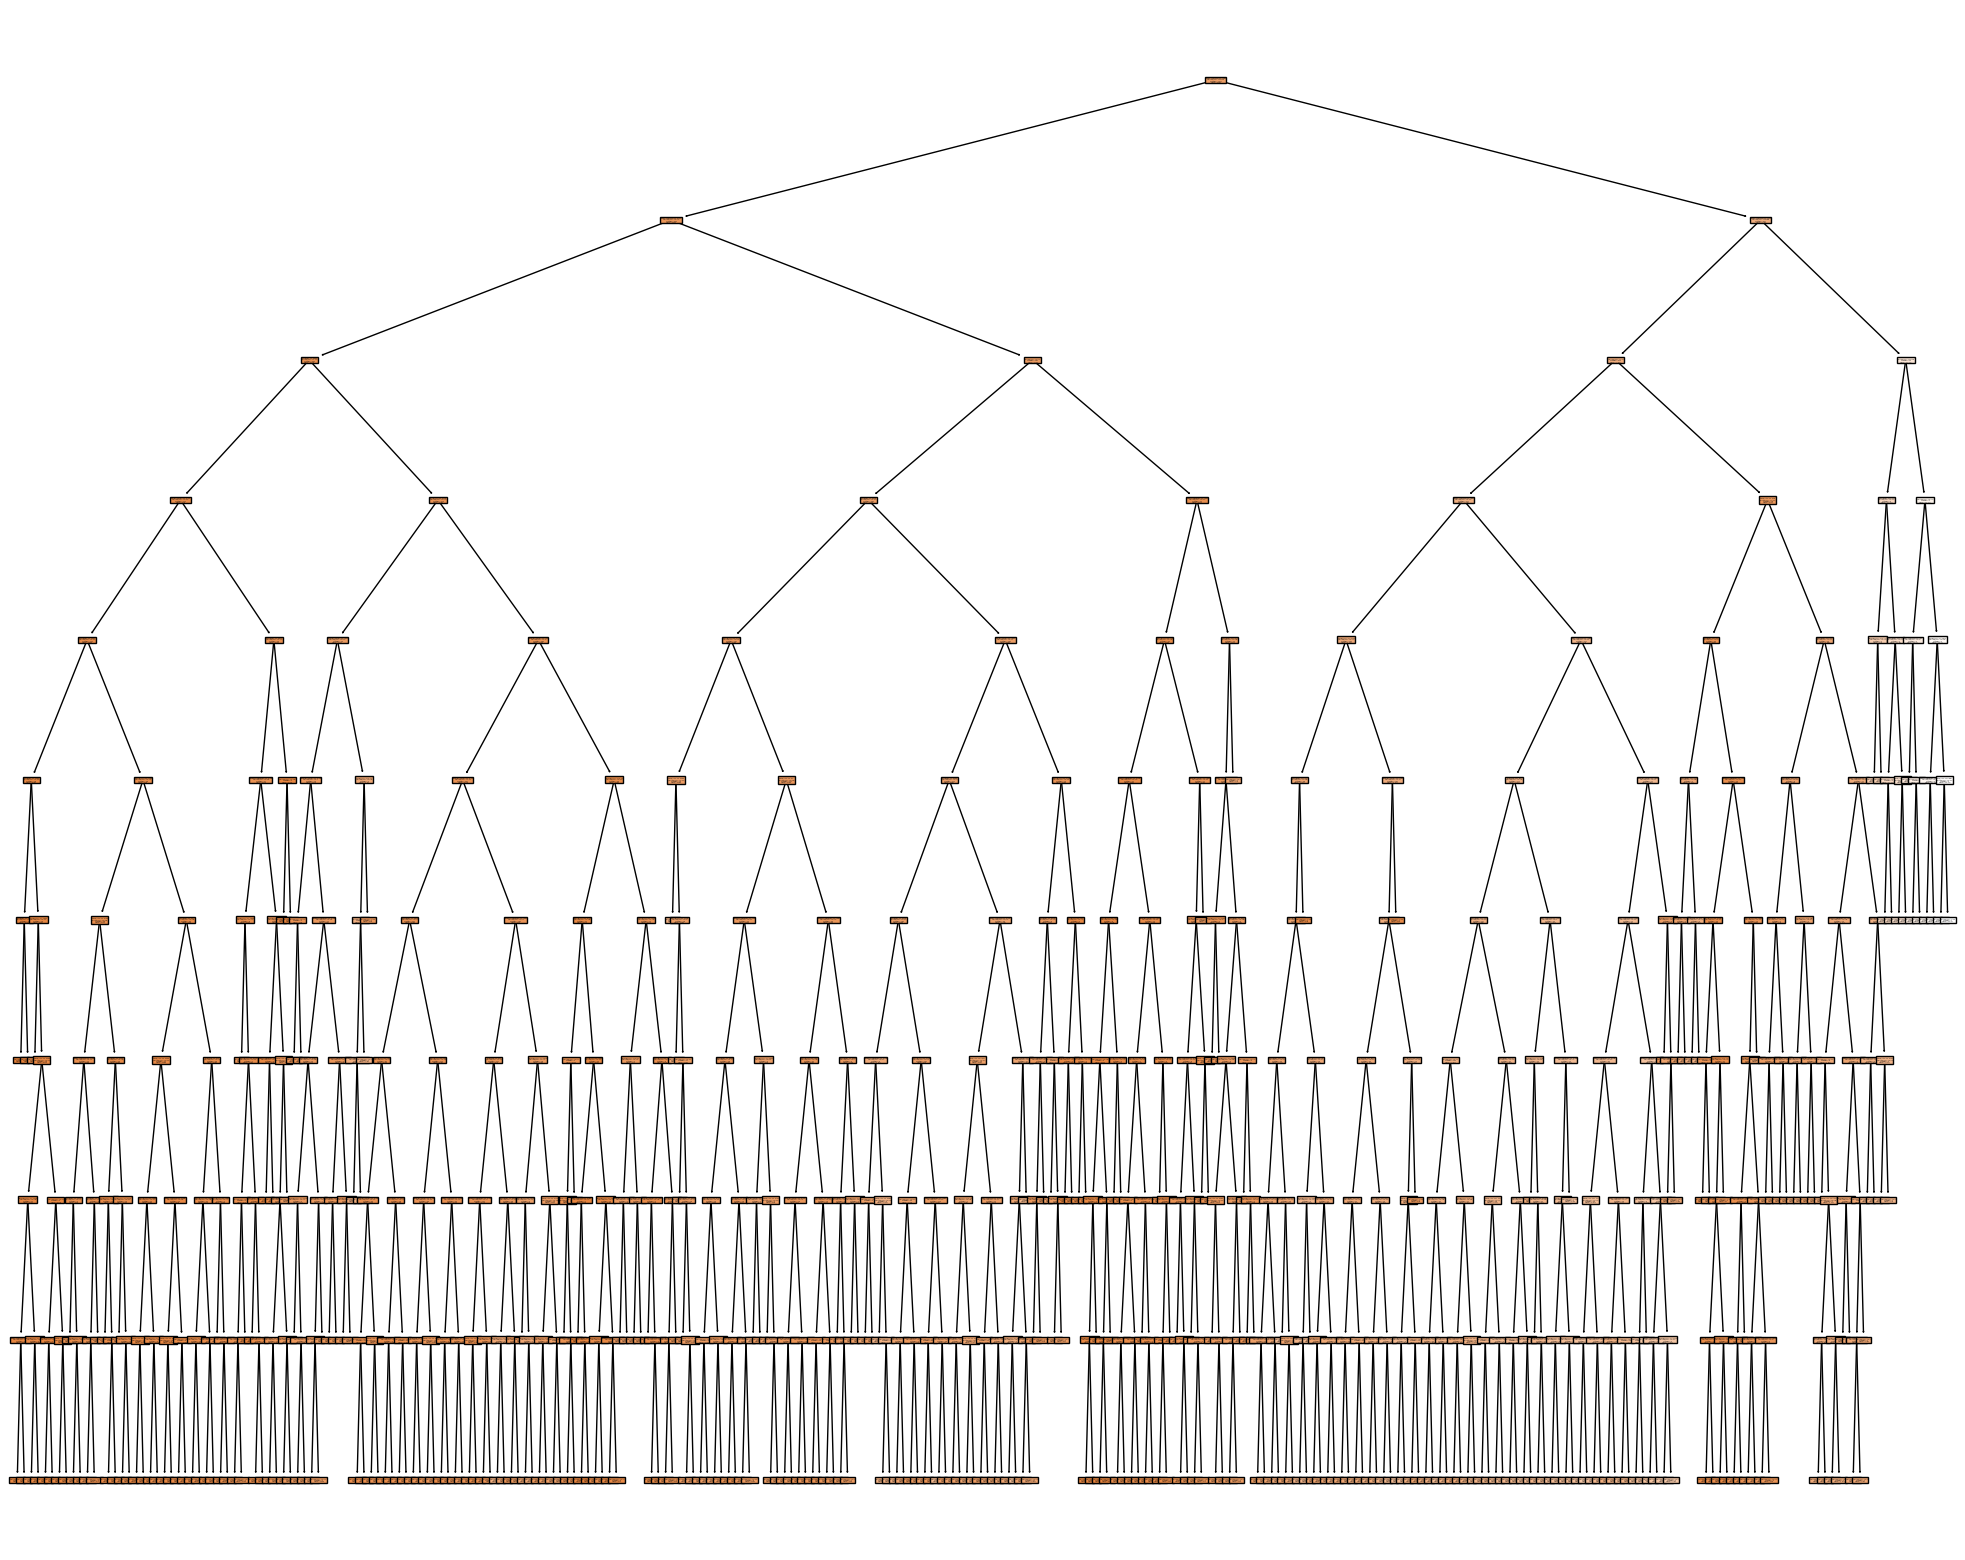

In [104]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_model,
                   feature_names=X_train.columns,
                   filled=True)

## Модель случайного леса

Суть алгоритма **случайного леса** заключается в том, что он создает множество решающих деревьев и использует их для предсказания классов объектов. Каждое дерево строится на случайном подмножестве обучающих данных и случайном подмножестве признаков. В результате, каждое дерево в ансамбле получается немного разным, что позволяет уменьшить эффект переобучения и повысить качество предсказаний.

In [18]:
# Строим случайный лес
from sklearn.ensemble import RandomForestRegressor
forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)
forest_pred_train = forest_model.predict(X_train)
forest_pred_test = forest_model.predict(X_test)
print('Случайный лес:')
print('Обучающая выборка:')
print('RMSE:', mean_squared_error(y_train, forest_pred_train) ** 0.5)
print('R^2:', r2_score(y_train, forest_pred_train))
print('Тестовая выборка:')
print('RMSE:', mean_squared_error(y_test, forest_pred_test) ** 0.5)
print('R^2:', r2_score(y_test, forest_pred_test))

Случайный лес:
Обучающая выборка:
RMSE: 0.3410335957787939
R^2: 0.9895454031406282
Тестовая выборка:
RMSE: 0.7895328389151057
R^2: 0.9307981698544714


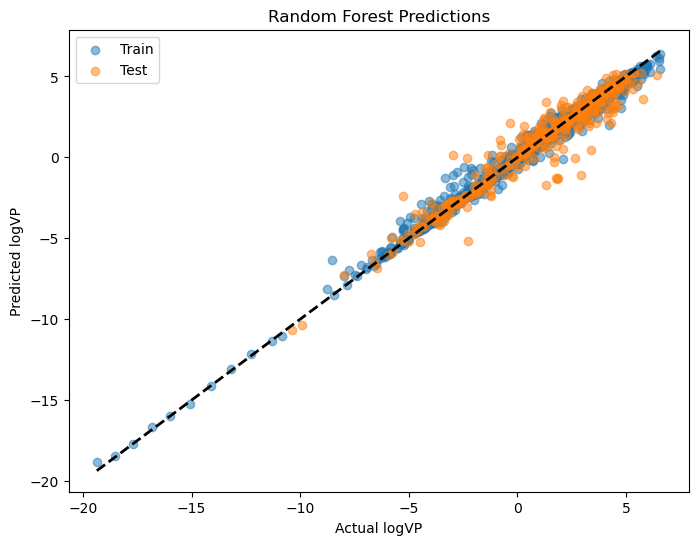

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train, forest_pred_train, alpha=0.5, label='Train')
plt.scatter(y_test, forest_pred_test, alpha=0.5, label='Test')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual logVP')
plt.ylabel('Predicted logVP')
plt.title('Random Forest Predictions')
plt.legend()
plt.show()

# Целеноправленный поиск подходящей модели МО

Существует большое количество разных моделей МО. Все они основаны на различных математических опреациях и могут проявлять себя по-разному в зависимости от данных. Поэтому, чтобы не перебирать их все вручную, возможно подобрать самую эффективную модель для нашей конкретной задачи с использованием библиотеки `lazypredict`

In [1]:
pip install lazypredict

Note: you may need to restart the kernel to use updated packages.


In [16]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

In [17]:
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  7.03it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1289
[LightGBM] [Info] Number of data points in the train set: 1524, number of used features: 9
[LightGBM] [Info] Start training from score 0.877073


In [18]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
XGBRegressor,0.94,0.94,0.81,0.12
MLPRegressor,0.94,0.94,0.84,0.99
ExtraTreesRegressor,0.94,0.94,0.84,0.67
LGBMRegressor,0.92,0.92,0.93,0.17
GradientBoostingRegressor,0.92,0.92,0.95,0.48
HistGradientBoostingRegressor,0.92,0.92,0.96,0.82
RandomForestRegressor,0.92,0.92,0.97,0.89
BaggingRegressor,0.91,0.92,0.99,0.16
KNeighborsRegressor,0.91,0.92,0.99,0.02


In [19]:
from xgboost import XGBRegressor

In [22]:
XGBR_model = XGBRegressor(objective='reg:squarederror', random_state=42)
XGBR_model.fit(X_train, y_train)
XGBR_pred_train = XGBR_model.predict(X_train)
XGBR_pred_test = XGBR_model.predict(X_test)
print('XGBRegressor:')
print('Обучающая выборка:')
print('RMSE:', mean_squared_error(y_train, linear_pred_train) ** 0.5)
print('R^2:', r2_score(y_train, linear_pred_train))
print('Тестовая выборка:')
print('RMSE:', mean_squared_error(y_test, linear_pred_test) ** 0.5)
print('R^2:', r2_score(y_test, linear_pred_test))

XGBRegressor:
Обучающая выборка:
RMSE: 0.11759883797649454
R^2: 0.9986813371440716
Тестовая выборка:
RMSE: 0.8092568925830066
R^2: 0.9433923934353975


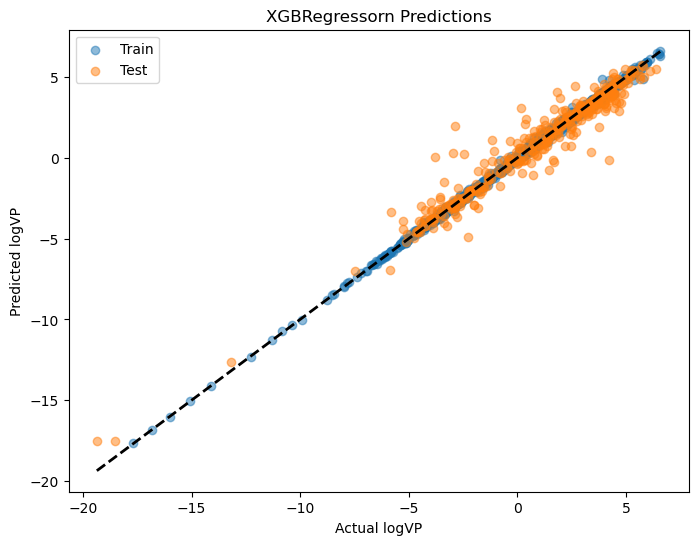

In [23]:
# Построим график предсказанных значений в сопоставлении с реальными
plt.figure(figsize=(8, 6))
plt.scatter(y_train, linear_pred_train, alpha=0.5, label='Train')
plt.scatter(y_test, linear_pred_test, alpha=0.5, label='Test')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual logVP')
plt.ylabel('Predicted logVP')
plt.title('XGBRegressorn Predictions')
plt.legend()
plt.show()

# Использование модели МО

Теперь, когда мы построили оптимальную модель (XGBRegressor) для расчета давления насыщенных паров, мы можем предсказать давление для собственной молекулы. Для этого нам нужно для начала посчитать все дескрипторы, которые мы использовали для предсказания. А затем просто ввести SMILES молекулы

In [24]:
import warnings
warnings.filterwarnings('ignore')

smiles = input('Введите SMILES молекулы ')
mol = Chem.MolFromSmiles(smiles)

# Вычисляем дескрипторы молекулы
descriptors_rdkit = np.array([d(mol) for d in desсriptors]).reshape(1, -1)

# Проводим нормализацию, как на этапе обучения
descriptors_rdkit = scaler.transform(descriptors_rdkit)

# Используем модель XGBRegressor для предсказания logVP
X_new = descriptors_rdkit
logVP_pred = XGBR_model.predict(X_new)[0]

print(f'Предсказанное значение давления насыщенных паров для {smiles} = %.3f' % (logVP_pred))

Введите SMILES молекулы  FC(C(CC(C(F)(F)F)=O)=O)(F)F


Предсказанное значение давления насыщенных паров для FC(C(CC(C(F)(F)F)=O)=O)(F)F = 4.524


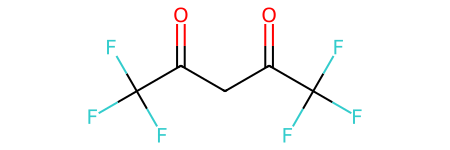

In [127]:
mol = Chem.MolFromSmiles('FC(C(CC(C(F)(F)F)=O)=O)(F)F')
mol
# 4.242 => https://www.chemsrc.com/en/cas/1522-22-1_899990.html

Мы предсказали давление насыщенного пара для соединения, которого нет в исходной базе. Экспериментальное значение для данного соединения равно 4.24 `[https://www.chemsrc.com/en/cas/1522-22-1_899990.html]`. Таким образом, мы видим, что значение близко к предсказанному. Ура!

In [26]:
import warnings
warnings.filterwarnings('ignore')

smiles = input('Введите SMILES молекулы ')
mol = Chem.MolFromSmiles(smiles)

# Вычисляем дескрипторы молекулы
descriptors_rdkit = np.array([d(mol) for d in desсriptors]).reshape(1, -1)

# Проводим нормализацию, как на этапе обучения
descriptors_rdkit = scaler.transform(descriptors_rdkit)

# Используем модель XGBRegressor для предсказания logVP
X_new = descriptors_rdkit
logVP_pred = XGBR_model.predict(X_new)[0]

print(f'Предсказанное значение давления насыщенных паров для {smiles} = %.3f' % (logVP_pred))

Введите SMILES молекулы  C(C)N(C(C)=NP(=O)(OCC)F)CC


Предсказанное значение давления насыщенных паров для C(C)N(C(C)=NP(=O)(OCC)F)CC = -0.428


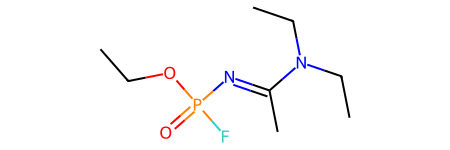

In [130]:
mol = Chem.MolFromSmiles('C(C)N(C(C)=NP(=O)(OCC)F)CC')
mol

Далее представлено значение насыщенных паров для соединения из класса "Новичков", чьи экспериментальные значения получить было бы затруднетельно. Данное значение представляет собой оценку, это лучше, чем не иметь никаких данных

In [27]:
import warnings
warnings.filterwarnings('ignore')

smiles = input('Введите SMILES молекулы ')
mol = Chem.MolFromSmiles(smiles)

# Вычисляем дескрипторы молекулы
descriptors_rdkit = np.array([d(mol) for d in desсriptors]).reshape(1, -1)

# Проводим нормализацию, как на этапе обучения
descriptors_rdkit = scaler.transform(descriptors_rdkit)

# Используем модель XGBRegressor для предсказания logVP
X_new = descriptors_rdkit
logVP_pred = XGBR_model.predict(X_new)[0]

print(f'Предсказанное значение давления насыщенных паров для {smiles} = %.3f' % (logVP_pred))

Введите SMILES молекулы  c1cc6cc(c1)c2cccc(c2)c3cccc(c3)c4cccc(c4)c5cccc(c5)c7cccc6c7


Предсказанное значение давления насыщенных паров для c1cc6cc(c1)c2cccc(c2)c3cccc(c3)c4cccc(c4)c5cccc(c5)c7cccc6c7 = -9.015


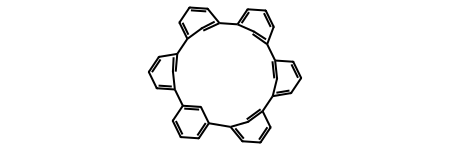

In [126]:
mol = Chem.MolFromSmiles('c1cc6cc(c1)c2cccc(c2)c3cccc(c3)c4cccc(c4)c5cccc(c5)c7cccc6c7')
mol

Более того, мы можем выяснить значение насыщенных паров для *вымышленных* молекул. Значение давления насыщенных паров для этой молекулы очень низкое, что кажется довольно логичным и правильным.